# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

import PIL
import requests
import random
import pickle
from tensorflow.keras import layers

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
import pathlib

from tensorflow.keras.callbacks import EarlyStopping
from skimage.filters import gabor
from skimage.filters import gabor_kernel
# importing Dependencies

import os
import glob

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers
import tensorflow.keras as keras


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate,Conv2D,MaxPooling2D, Flatten,Dense,BatchNormalization

from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model
# from tensorflow.keras.callbacks import ReduceLROnPlateau

#from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

from sklearn import metrics

from tqdm.notebook import tqdm
import random
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from time import time
from collections import Counter

from PIL import Image
from random import shuffle

import tensorflow as tf
from tensorflow.keras.metrics import AUC

import keras
import keras.backend as K
import keras.layers as L
from keras import Model
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Importing the Dataset

In [2]:
##### import os
import cv2
import numpy as np
from multiprocessing import Pool
# using all 4 threads to import the image, similar code will be seen in the  notebook. Codes that use Multi processing etc


SIZE =  512 # change image to 256 256 if you want to do HCNN, 512 is AAEs
DCT_S = 64 # change to 32 if the image is 256 by 256 , reshaping later on needs this parameter. 
BATCH_SIZE = 32 # Not important
TARGET_SIZE = (SIZE, SIZE)
LIMIT_PER_FOLDER = 300  # Maximum number of files per folder , GPU CNN at 256 256 ~1000 , GPU AEs ~ 350

dir_path = '/kaggle/input/alaskas-v2-binary/ALASKA/ALASKA/Train'

def load_image(img):
    try:
        img_path = img[0]
        folder = img[1]
        
        image = cv2.imread(img_path, 3)
        image = cv2.resize(image, TARGET_SIZE)
        image = np.array(image)
        
        return image, folder
    except:
        return None

images = []
labels = []  

image_paths = []
for folder in os.listdir(dir_path):
    if folder == "Test" or folder == "sample_submission.csv":
        continue
    folder_path = os.path.join(dir_path, folder)
    file_counter = 0  # Counter to keep track of the number of files per folder
    for img in os.listdir(folder_path):
        if file_counter >= LIMIT_PER_FOLDER:
            break
        
        img_path = os.path.join(folder_path, img)
        image_paths.append((img_path, folder))
        file_counter += 1

pool = Pool(processes=4)
results = pool.map(load_image, image_paths)
pool.close()
pool.join()

results = [result for result in results if result is not None]
images, labels = zip(*results)
images = np.array(images)
labels = np.array(labels)


# Splitting the Dataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the initial StratifiedShuffleSplit for train-test split
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in ss.split(images, labels):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

# Shuffle the train set before further splitting
shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Split the train set into train and validation sets using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in sss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]


In [5]:
print(len(y_val))
print(len(y_train))
print(len(y_test))

96
384
120


In [6]:
# save on ram 
del images 
del labels

# DCT YCCBR & RGB Features for AEs 
This part extracts the DCT features using Multi threading 

In [7]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor

DCT_Train = []
DCT_Test = []
DCT_Val = []

def process_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB color space

    # Convert image to YCbCr color space
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Split the image into individual channels
    channels = cv2.split(ycbcr_image)

    # Apply DCT to each channel
    dct_coeffs = []
    for channel in channels:
        dct_coeffs.append(cv2.dct(np.float32(channel)))

    # Reshape DCT coefficients as input channels
    dct_channels = np.concatenate(dct_coeffs, axis=-1)
    dct_channels = dct_channels.reshape(-1, DCT_S, DCT_S)
    return dct_channels

def featureAEDCT(img, folder):
    dct_channels = process_image(img)
    if folder == "Train":
        DCT_Train.append(dct_channels)
    elif folder == "Test":
        DCT_Test.append(dct_channels)
    else:
        DCT_Val.append(dct_channels)

# Load your X_train, X_test, and X_val data here

# Process images using multiple threads
with ThreadPoolExecutor(max_workers=4) as executor:
    # Process train images
    train_futures = [executor.submit(featureAEDCT, img, "Train") for img in X_train]

    # Process test images
    test_futures = [executor.submit(featureAEDCT, img, "Test") for img in X_test]

    # Process validation images
    val_futures = [executor.submit(featureAEDCT, img, "Val") for img in X_val]

# Wait for all threads to complete
for future in train_futures + test_futures + val_futures:
    future.result()


In [8]:
DCT_Train = np.array(DCT_Train)
DCT_Val = np.array(DCT_Val)
DCT_Test = np.array(DCT_Test)

# RGB Channel (4-way, modeling)
Doesnt seem to show any improvement, code works, just uncomment, require more ram and gpu

In [11]:
# DCT_Train_RGB = []
# DCT_Test_RGB = []
# DCT_Val_RGB = []

# #rgb
# def process_image(img):
#     image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB color space


#     # Split the image into individual channels
#     channels = cv2.split(image)

#     # Apply DCT to each channel
#     dct_coeffs = []
#     for channel in channels:
#         dct_coeffs.append(cv2.dct(np.float32(channel)))

#     # Reshape DCT coefficients as input channels
#     dct_channels = np.concatenate(dct_coeffs, axis=-1)
#     dct_channels = dct_channels.reshape(-1, 32, 32)
#     return dct_channels

# def featureAEDCT(img, folder):
#     dct_channels = process_image(img)
#     if folder == "Train":
#         DCT_Train_RGB.append(dct_channels)
#     elif folder == "Test":
#         DCT_Test_RGB.append(dct_channels)
#     else:
#         DCT_Val_RGB.append(dct_channels)

# # Load your X_train, X_test, and X_val data here

# # Process images using multiple threads
# with ThreadPoolExecutor(max_workers=4) as executor:
#     # Process train images
#     train_futures = [executor.submit(featureAEDCT, img, "Train") for img in X_train]

#     # Process test images
#     test_futures = [executor.submit(featureAEDCT, img, "Test") for img in X_test]

#     # Process validation images
#     val_futures = [executor.submit(featureAEDCT, img, "Val") for img in X_val]

# # Wait for all threads to complete
# for future in train_futures + test_futures + val_futures:
#     future.result()


In [12]:
# DCT_Train_RGB = np.array(DCT_Train_RGB)
# DCT_Val_RGB = np.array(DCT_Val_RGB)
# DCT_Test_RGB = np.array(DCT_Test_RGB)

# Model Building 

In [39]:
def build_cnn():
    model = Sequential()
    pretrained_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False,
                      input_shape=(SIZE,SIZE,3),
                      pooling='avg',classes=2,
                      weights="imagenet")
    # Unfreezing all layers due to the complete difference in dataset, initialised on imagenet weights , from discussion from the winner of the competition
    for layer in pretrained_model.layers:
             layer.trainable=True 

    model.add(pretrained_model)
    model.add(Flatten())
    
    model.add(Dense(1408, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    

    return model


def build_advanced_encoder():
    input_layer = keras.Input(shape=(192, DCT_S, DCT_S), name='Input')

    # Encoder
    encoded = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(input_layer)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2))(encoded)
    encoded = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2))(encoded)
    encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2))(encoded)
    encoded = keras.layers.Flatten()(encoded)
    encoded = keras.layers.Dense(128, activation='relu')(encoded)

    # Define the model
    model = keras.Model(inputs=input_layer, outputs=encoded)
    return model


# def build_advanced_encoder_RGB():
#     input_layer = keras.Input(shape=(192, 32, 32), name='RGB')

#     # Encoder
#     encoded = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(input_layer)
#     encoded = keras.layers.BatchNormalization()(encoded)
#     encoded = keras.layers.MaxPooling2D((2, 2))(encoded)
#     encoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
#     encoded = keras.layers.BatchNormalization()(encoded)
#     encoded = keras.layers.MaxPooling2D((2, 2))(encoded)
#     encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
#     encoded = keras.layers.BatchNormalization()(encoded)
#     encoded = keras.layers.MaxPooling2D((2, 2))(encoded)
#     encoded = keras.layers.Flatten()(encoded)
#     encoded = keras.layers.Dense(32, activation='relu')(encoded)

#     # Define the model
#     model = keras.Model(inputs=input_layer, outputs=encoded)
#     return model


# SRNET: https://www.kaggle.com/code/pednt9/alaska2-srnet-in-keras/notebook
def layer_type1(x_inp, filters, kernel_size=(3, 3), dropout_rate=0):
    x = L.Conv2D(filters, kernel_size, padding="same")(x_inp)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    if dropout_rate > 0:
        x = L.Dropout(dropout_rate)(x)

    return x

def layer_type2(x_inp, filters, kernel_size=(3, 3), dropout_rate=0):
    x = layer_type1(x_inp, filters)
    x = L.Conv2D(filters, kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    if dropout_rate > 0:
        x = L.Dropout(dropout_rate)(x)

    x = L.Add()([x, x_inp])
    
    return x

def layer_type3(x_inp, filters, kernel_size=(3, 3), dropout_rate=0):
    x = layer_type1(x_inp, filters)
    x = L.Conv2D(filters, kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    x = L.AveragePooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    if dropout_rate > 0:
        x = L.Dropout(dropout_rate)(x)
        
    x_res = L.Conv2D(filters, kernel_size, strides=(2, 2))(x_inp)
    x_res = L.BatchNormalization()(x_res)
    if dropout_rate > 0:
        x_res = L.Dropout(dropout_rate)(x_res)

    x = L.Add()([x, x_res])
    
    return x

def layer_type4(x_inp, filters, kernel_size=(3, 3), dropout_rate=0):
    x = layer_type1(x_inp, filters)
    x = L.Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
    x = L.BatchNormalization()(x)
    if dropout_rate > 0:
        x = L.Dropout(dropout_rate)(x)    
    x = L.GlobalAveragePooling2D()(x)
    
    return x

def make_model(input_shape=(SIZE, SIZE, 3), num_type2=5, dropout_rate=0):

    # I reduced the size (image size, filters and depth) of the original network because it was way to big
    inputs = L.Input(shape=input_shape)
    
    x = layer_type1(inputs, filters=64, dropout_rate=dropout_rate)
    x = layer_type1(x, filters=16, dropout_rate=dropout_rate)    
    
    for _ in range(num_type2):
        x = layer_type2(x, filters=16, dropout_rate=dropout_rate)         
    
    x = layer_type3(x, filters=16, dropout_rate=dropout_rate) 
    x = layer_type3(x, filters=32, dropout_rate=dropout_rate)            
    x = layer_type3(x, filters=64, dropout_rate=dropout_rate)            
    x = layer_type3(x, filters=128, dropout_rate=dropout_rate) 
    
    x = layer_type4(x, filters=128, dropout_rate=dropout_rate)        
    
    x = L.Dense(64)(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    if dropout_rate > 0:
        x = L.Dropout(dropout_rate)(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [40]:
cnn = build_cnn()
DALP_DCT_YCCBR = build_advanced_encoder()
#DALP_DCT_RGB = build_advanced_encoder_RGB()
SRNET_P = make_model() # Because why not ? Run if you care for every bit of accuracy and ditched optimising inference or training speed. Run if you have > 32 GB Ram, or a V100 - 3090. Convergence is slower.

combinedInput = concatenate([DALP_DCT_YCCBR.output, cnn.output,SRNET_P.output])

x = Dense(1408, activation="relu")(combinedInput)
keras.layers.BatchNormalization()(x)
x = Dropout(0.15216540534179496)(x)
x = Dense(128, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)  
x = Dense(32, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.15216540534179496)(x)
x = Dense(4, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[DALP_DCT_YCCBR.input, cnn.input,SRNET_P.input], outputs=x)

43941136/43941136 [==============================] - 0s 0us/step


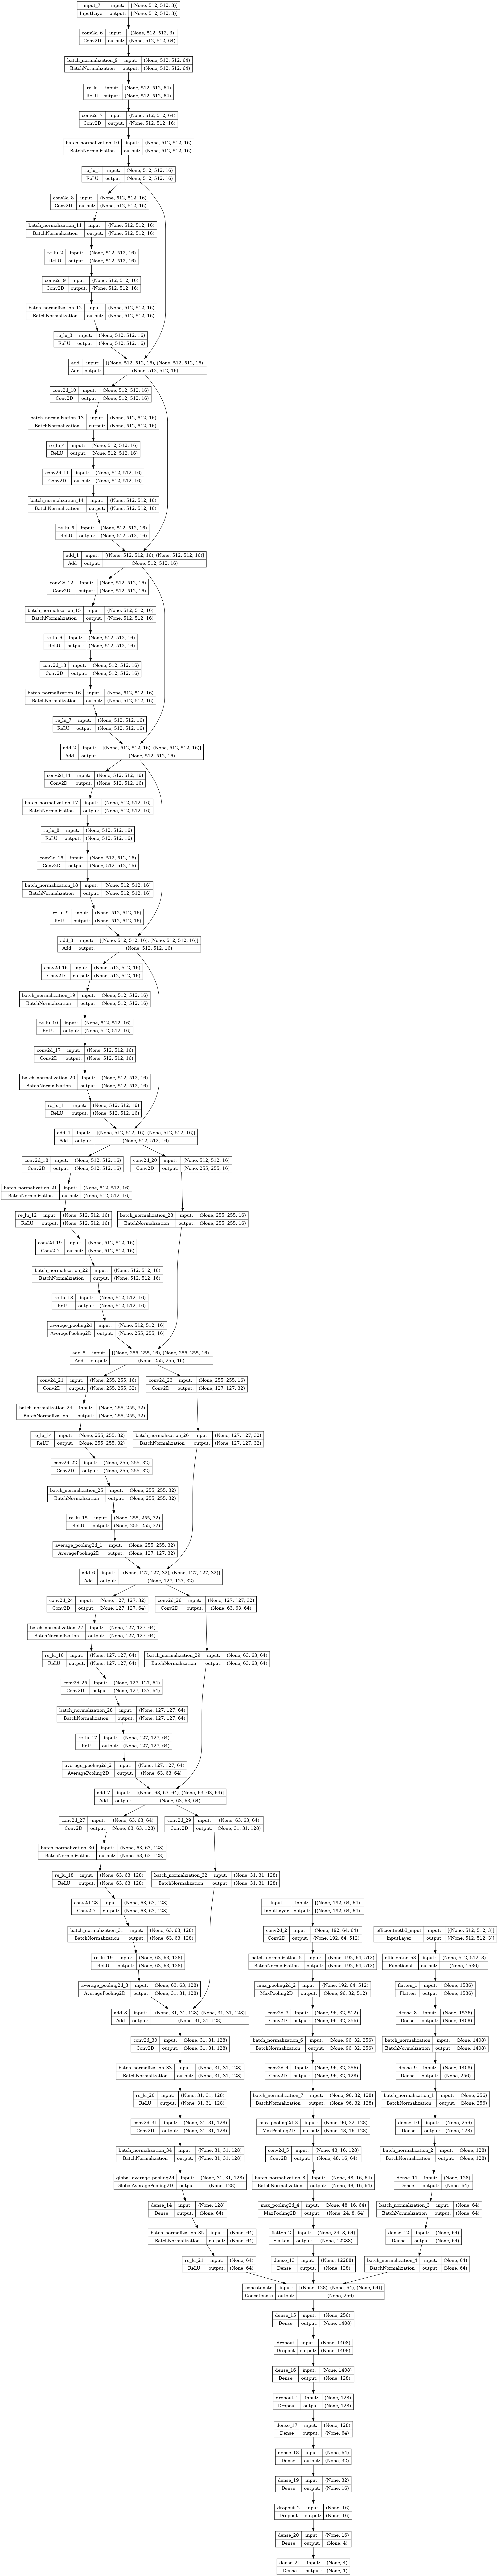

In [41]:
plot_model(model, show_shapes=True, to_file="model.png")

# Data Preprocessing for modeling 

In [8]:
# conversion to YCrCB color space 
train_images_SR = []
test_images_SR = []
val_images_SR = []

for i in X_train : 
    train_images_SR.append(cv2.cvtColor(i, cv2.COLOR_BGR2YCrCb))
for i in X_test: 
    test_images_SR.append(cv2.cvtColor(i, cv2.COLOR_BGR2YCrCb))
for i in X_val: 
    val_images_SR.append(cv2.cvtColor(i, cv2.COLOR_BGR2YCrCb))

In [9]:
train_images_SR =np.array(train_images_SR)
test_images_SR =np.array(test_images_SR)
val_images_SR =np.array(val_images_SR)

In [19]:
train_images_norm_SR = train_images_SR.astype('float32')
test_images_norm_SR = test_images_SR.astype('float32')
val_images_norm_SR = val_images_SR.astype('float32')
# normalize to the range 0-1
train_images_norm_SR /= 255.0
test_images_norm_SR /= 255.0
val_images_norm_SR /= 255.0

In [12]:
from sklearn.preprocessing import LabelEncoder
# Convert the labels to numerical values , from "Fake" == 0 'True' == 1
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_val= encoder.fit_transform(y_val)

In [13]:
from tensorflow.keras.utils import to_categorical

#distinct & model input requirement
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [15]:
 #Convert the input data to numpy arrays, images need to be converted to NP array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [16]:
train_images_norm = X_train.astype('float32')
test_images_norm = X_test.astype('float32')
val_images_norm = X_val.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

# Competition Metric

In [19]:
def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]
    
    fpr, tpr, thresholds = roc_curve(y_true, y_valid)
    
    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    try:
    
        competition_metric = 0
        for idx, weight in enumerate(weights):
            y_min = tpr_thresholds[idx]
            y_max = tpr_thresholds[idx + 1]
            mask = (y_min < tpr) & (tpr < y_max)

            x_padding = np.linspace(fpr[mask][-1], 1, 100)

            x = np.concatenate([fpr[mask], x_padding])
            y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
            y = y - y_min # normalize such that curve starts at y=0
            score = auc(x, y)
            submetric = score * weight
            best_subscore = (y_max - y_min) * weight
            competition_metric += submetric
    except:
        # sometimes there's a weird bug so return naive score
        return .5
        
    return competition_metric / normalization

def alaska_tf(y_true, y_val):
    """Wrapper for the above function"""
    return tf.py_function(func=alaska_weighted_auc, inp=[y_true, y_val], Tout=tf.float32)

# Application of Label Smoothing

In [20]:
def label_smoothing(y_true,y_pred):
     return tf.keras.losses.binary_crossentropy(y_true,y_pred,label_smoothing=0.05)

# MODEL FITTING

In [38]:
import tensorflow as tf
import tensorflow_addons as tfa
# Better version of Adam and SGD, recommended to be used in the literature
optimizer = tfa.optimizers.AdamW(weight_decay=0.000001)

In [ ]:
model.compile(optimizer=optimizer, loss=label_smoothing, metrics=[alaska_tf])

In [10]:
# model.load_weights('/kaggle/working/best_model_weights.h5')
del X_train
del X_test
del X_val
gc.collect() # clears up memory

0

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_alaska_tf', patience=10,restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Model Callbacks 
ROP = [
    ReduceLROnPlateau(
        monitor='val_alaska_tf',
        factor=0.1,
        patience=3,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-10,
        verbose=1,
    )
] 

# dataset_label = tf.data.Dataset.from_tensor_slices(y_train)
from keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback to save the weights of the best model
checkpoint = ModelCheckpoint('/kaggle/working/best_model_weights.h5', monitor='val_alaska_tf', save_best_only=True, save_weights_only=True, mode='max', verbose=1)


# fit model
early_stopping = EarlyStopping(monitor='val_alaska_tf', patience=15,restore_best_weights=True)
# The bigger the batch the better 
history = model.fit(x=[DCT_Train, train_images_norm,train_images_norm_SR],y=y_train[:,0],epochs = 25, batch_size=16,validation_data=([DCT_Test,test_images_norm,test_images_norm_SR],y_test[:,0]),callbacks=([early_stopping,checkpoint]))

Epoch 1/25


2023-05-26 14:41:35.103253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/60 [==============================] - ETA: 0s - loss: 0.7054 - alaska_tf: 0.5879
Epoch 1: val_alaska_tf improved from -inf to 0.55735, saving model to /kaggle/working/best_model_weights.h5
60/60 [==============================] - 75s 739ms/step - loss: 0.7054 - alaska_tf: 0.5879 - val_loss: 0.6938 - val_alaska_tf: 0.5573
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 0.6942 - alaska_tf: 0.5725
Epoch 2: val_alaska_tf improved from 0.55735 to 0.56805, saving model to /kaggle/working/best_model_weights.h5
60/60 [==============================] - 37s 615ms/step - loss: 0.6942 - alaska_tf: 0.5725 - val_loss: 0.6935 - val_alaska_tf: 0.5680
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 0.6991 - alaska_tf: 0.5650
Epoch 3: val_alaska_tf did not improve from 0.56805
60/60 [==============================] - 37s 615ms/step - loss: 0.6991 - alaska_tf: 0.5650 - val_loss: 0.6942 - val_alaska_tf: 0.5313
Epoch 4/25
60/60 [==============================] - E

# Model Evaluation 

In [26]:
model.load_weights('best_model_weights.h5')

score = model.evaluate([DCT_Val,val_images_norm,val_images_norm],y=y_val[:,0], batch_size=32)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

8/8 [==============================] - 4s 185ms/step - loss: 0.6934 - alaska_tf: 0.5264
Test loss: 0.6934071779251099 / Test accuracy: 0.526356041431427


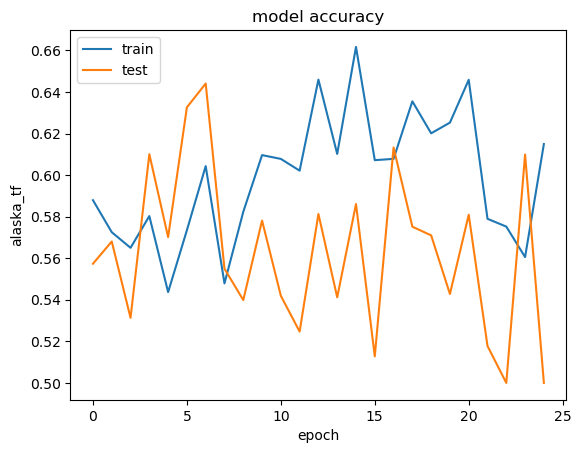

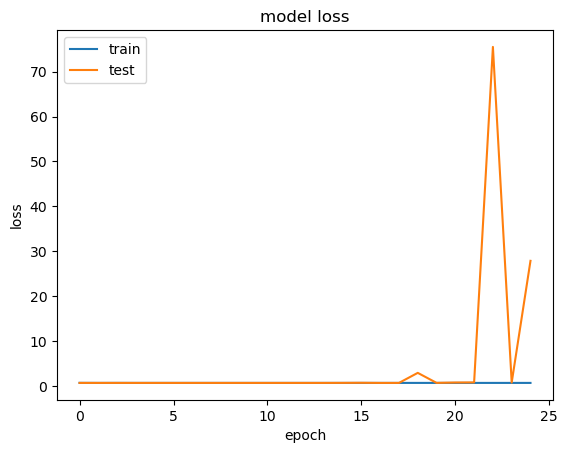

In [27]:
plt.plot(history.history['alaska_tf'])
plt.plot(history.history['val_alaska_tf'])
plt.title('model accuracy')
plt.ylabel('alaska_tf')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model optimization 

In [ ]:
from bayes_opt import BayesianOptimization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the function to optimize
def optimize_model(learning_rate, batch_size, dropout_rate):

    # Create a ModelCheckpoint callback to save the weights of the best model
    checkpoint = ModelCheckpoint('/kaggle/working/best_model_weights.h5', monitor='val_alaska_tf', save_best_only=True, save_weights_only=True, mode='max', verbose=1)
    combinedInput = concatenate([DALP_DCT_YCCBR.output, cnn.output,SRNET_P.output])

    x = Dense(1408, activation="relu")(combinedInput)
    keras.layers.BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation="relu")(x)  
    keras.layers.BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(4, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=[DALP_DCT_YCCBR.input, cnn.input,SRNET_P.input], outputs=x)
    
        # Model Callbacks 
    ROP = [
        ReduceLROnPlateau(
            monitor='val_alaska_tf',
            factor=0.1,
            patience=3,
            mode='auto',
            min_delta=0.0002,
            cooldown=5,
            min_lr=10e-10,
            verbose=1,
        )
    ] 

    optimizer = tfa.optimizers.AdamW(weight_decay=0.000001,lr=learning_rate)
    model.compile(optimizer=optimizer, loss=label_smoothing, metrics=[alaska_tf])
    
    history = model.fit(x=[DCT_Train, train_images_norm,train_images_norm_SR],y=y_train[:,0],epochs = 15, batch_size=int(batch_size),validation_data=([DCT_Test,test_images_norm,test_images_norm_SR],y_test[:,0]),callbacks=([checkpoint]))
    # Get the validation accuracy
    accuracy = history.history['val_alaska_tf'][-1]
    
    # Return the negative accuracy (since we want to maximize the accuracy)
    return accuracy

# Create the Bayesian optimization object , Less data less params , curse of dimensionality if too many params 
bounds = {'learning_rate': (1e-10,1e-4), 'batch_size': (16,24),'dropout_rate': (0.1, 0.4)}
bo = BayesianOptimization(optimize_model,bounds)
bo.maximize(init_points=5, n_iter=10)

# Print the best hyperparameters
print("Best hyperparameters:", bo.max)

# Standard CNN Transfer Learning model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam, SGD

train_datagen = ImageDataGenerator(rescale=1./255,vertical_flip = 0.5,
horizontal_flip = 0.5)

val_datagen = ImageDataGenerator(rescale=1./255)
# can we scale image down in return for a more robust model using features extraction ?
train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/alaskas-v2-binary/ALASKA/ALASKA/Train',
        target_size=(512, 512),
        batch_size=20,
        class_mode='binary',shuffle=True)

val_generator = val_datagen.flow_from_directory(
        '/kaggle/input/alaskas-v2-binary/ALASKA/ALASKA/Test',
        target_size=(512, 512),
        batch_size=512,
        class_mode='binary',shuffle=False)


# Define the model
model = Sequential()
pretrained_model=tf.keras.applications.efficientnet.EfficientNetB2(include_top=False,
                      input_shape=(512,512,3),
                      pooling='avg',classes=2,
                      weights='imagenet')
for layer in pretrained_model.layers:
         layer.trainable=True 
x = Flatten()(pretrained_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[alaska_tf])

model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=75)
score = model.evaluate(val_generator, steps=len(val_generator))
print('Validation Loss:', score[0])
print('Validation Accuracy:', score[1])


# RL Model for Image Classification 

Reference : https://www.brthor.com/blog/ai/reinforcement-learning/can-reinforcement-learning-be-used-for-classification/

In [ ]:
!pip install stable-baselines3
!pip install gym
!pip install opencv-python
!pip install torch
!pip install tensorflow
!pip install keras

In [ ]:
# Define the checkpoint callback
from stable_baselines3.common.callbacks import CheckpointCallback
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='/kaggle/working/', name_prefix='ppo_mnist')

In [ ]:
import time
import gym
import random
import numpy as np
from tensorflow import keras
import time
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.logger import configure

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Model / data parameters
num_classes = 2
input_shape = (26, 26,3)




class MnistEnv(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(train_images_norm, y_train[:,0]), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(1)
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=(256,256,3),
                                                dtype=np.float32)

        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        reward = int(action == self.expected_action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs


def mnist_ppo():
    env = DummyVecEnv([lambda: Monitor(MnistEnv(images_per_episode=1), './logs/mnist_ppo')])

    model = PPO(
        'MlpPolicy',
        env,
        verbose=1,
        n_steps=32,
        ent_coef=0.01,
        learning_rate=2.5e-5,
        batch_size=256,
        n_epochs=15,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2
    )

    model.learn(total_timesteps=int(1.2e5), callback=checkpoint_callback)
    return model


ppo_model =mnist_ppo()

In [ ]:
def mnist_ppo_eval(ppo_model):
    attempts, correct = 0,0

    env = DummyVecEnv([lambda: MnistEnv(images_per_episode=1, dataset=(x_test, y_test[:,0]), random=False)])
    
    try:
        while True:
            obs, done = env.reset(), [False]
            while not done[0]:
                action, _ = ppo_model.predict(obs)
                obs, rew, done, _ = env.step(action)

                attempts += 1
                if rew[0] > 0:
                    correct += 1

    except StopIteration:
        print()
        print('validation done...')
        print('Accuracy: {0}%'.format((float(correct) / attempts) * 100))

mnist_ppo_eval(ppo_model)

# Adverserial Auto Encoder 

In [28]:
count =0
for i in y_test[:,0]:
    if i == 0:
        count +=1

count_1 =0
for i in y_val[:,0]:
    if i == 0:
        count_1 +=1
        
        
    
print("Number of Negative Hits in Y_test: " + str(count))
print("Number of Negative Hits in Y_val: " + str(count_1))

Number of Negative Hits in Y_test: 60
Number of Negative Hits in Y_val: 48


In [18]:
#remove if ran
# del train_images_norm 
# del test_images_norm
# del val_images_norm

In [15]:
latent_dim = 64

In [16]:
import numpy as np
import tensorflow as tf

# Define the Autoencoder (AE) model


height = 512
width = 512
channels = 3
input_shape = (height, width, channels)

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(encoder_inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
encoder_outputs = tf.keras.layers.Dense(latent_dim, activation="relu")(x)
encoder = tf.keras.models.Model(encoder_inputs, encoder_outputs)

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(16 * 16 * 64, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape(target_shape=(16, 16, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.UpSampling2D(size=(4, 4))(x)  # Upsample to (64, 64, 64)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.UpSampling2D(size=(4, 4))(x)  # Upsample to (256, 256, 32)
x = tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)  # Upsample to (512, 512, 16)
decoder_outputs = tf.keras.layers.Conv2DTranspose(channels, kernel_size=(3, 3), activation="sigmoid", padding="same")(x)
decoder = tf.keras.models.Model(decoder_inputs, decoder_outputs)


# Autoencoder
autoencoder_inputs = tf.keras.layers.Input(shape=input_shape)
encoded = encoder(autoencoder_inputs)
decoded = decoder(encoded)
autoencoder = tf.keras.models.Model(autoencoder_inputs, decoded)

# Define the Discriminator for GAN
discriminator_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation="relu")(discriminator_inputs)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
discriminator_outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
discriminator = tf.keras.models.Model(discriminator_inputs, discriminator_outputs)

# Create a separate model for reconstructed samples
latent_space_samples = tf.keras.layers.Input(shape=(latent_dim,))
reconstructed_samples = decoder(latent_space_samples)

# Connect the models
validity = discriminator(latent_space_samples)
combined = tf.keras.models.Model(latent_space_samples, [reconstructed_samples, validity])

# Compile the models
autoencoder.compile(optimizer=optimizer, loss="mse")
discriminator.compile(optimizer=optimizer, loss="binary_crossentropy")
combined.compile(optimizer=optimizer, loss=["mse", "binary_crossentropy"], loss_weights=[0.9, 0.1])

# Train the models


In [17]:
epochs = 25
batch_size = 32

In [20]:

# Fitting the trainigg data to the model
autoencoder.fit(train_images_norm_SR, train_images_norm_SR, batch_size=batch_size, epochs=epochs)

# Generate random samples from the latent space
latent_space_samples = np.random.normal(size=(len(train_images_norm_SR), latent_dim))

# Create labels for the generated samples (0 for fake)
fake_labels = np.zeros((len(train_images_norm_SR), 1))

# Train the discriminator
discriminator.fit(latent_space_samples, fake_labels, batch_size=batch_size, epochs=epochs)

# Generate random samples from the latent space
latent_space_samples = np.random.normal(size=(len(train_images_norm_SR), latent_dim))

# Create labels for the generated samples (1 for valid)
valid_labels = np.ones((len(train_images_norm_SR), 1))

# Train the combined model
combined.fit(latent_space_samples, [train_images_norm_SR, valid_labels], batch_size=batch_size, epochs=epochs)


Epoch 1/25
12/12 [==============================] - 14s 266ms/step - loss: 0.0184
Epoch 2/25
12/12 [==============================] - 3s 261ms/step - loss: 0.0156
Epoch 3/25
12/12 [==============================] - 3s 243ms/step - loss: 0.0144
Epoch 4/25
12/12 [==============================] - 3s 241ms/step - loss: 0.0142
Epoch 5/25
12/12 [==============================] - 3s 240ms/step - loss: 0.0139
Epoch 6/25
12/12 [==============================] - 3s 229ms/step - loss: 0.0132
Epoch 7/25
12/12 [==============================] - 3s 226ms/step - loss: 0.0129
Epoch 8/25
12/12 [==============================] - 3s 223ms/step - loss: 0.0127
Epoch 9/25
12/12 [==============================] - 3s 240ms/step - loss: 0.0123
Epoch 10/25
12/12 [==============================] - 3s 232ms/step - loss: 0.0119
Epoch 11/25
12/12 [==============================] - 3s 235ms/step - loss: 0.0114
Epoch 12/25
12/12 [==============================] - 3s 221ms/step - loss: 0.0111
Epoch 13/25
12/12 [=====

# Anomalies Test Set


In [34]:
reconstructed_images = autoencoder.predict(test_images_norm_SR)
mse = np.mean(np.square(test_images_norm_SR - reconstructed_images), axis=(1, 2, 3))

threshold = np.percentile(mse, 60.5)
anomalies = np.where(mse > threshold)[0]
print(anomalies.shape)
print(f"Detected anomalies: {anomalies}")
print(f'accuracy: {anomalies.shape[0]/count*100}')

4/4 [==============================] - 1s 368ms/step
(48,)
Detected anomalies: [  0   2   9  10  11  13  14  16  19  20  22  24  25  27  28  29  33  34
  38  39  45  50  54  55  57  59  60  61  64  66  68  73  76  80  81  86
  87  88  89  96  98 103 107 108 109 110 112 119]
accuracy: 80.0


# Anomalies Validation set

In [36]:
reconstructed_images = autoencoder.predict(val_images_norm_SR)
mse = np.mean(np.square(val_images_norm_SR - reconstructed_images), axis=(1, 2, 3))

threshold = np.percentile(mse, 60.5)
anomalies = np.where(mse > threshold)[0]
print(anomalies.shape)
print(f"Detected anomalies: {anomalies}")
print(f'accuracy: {anomalies.shape[0]/count_1*100}')

3/3 [==============================] - 0s 80ms/step
(38,)
Detected anomalies: [ 0  3  9 10 15 16 22 30 32 33 34 35 40 42 48 49 50 53 57 61 62 65 66 67
 69 72 74 77 82 84 86 87 88 89 90 91 93 95]
accuracy: 79.16666666666666


# AAE Tuning Bayesian

In [20]:
def compute_metric(autoencoder, discriminator, combined, validation_data):
    # Perform inference using the autoencoder
    reconstructed_images = autoencoder.predict(validation_data)

    # Compute the mean squared error (MSE) between the reconstructed images and the original validation data
    mse = np.mean(np.square(reconstructed_images - validation_data))

    return -mse  # Return the metric to optimize (lower is better

In [ ]:
import numpy as np
import tensorflow as tf
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Define the hyperparameter search space
space = {
    'learning_rate_autoencoder': hp.loguniform('learning_rate_autoencoder', np.log(0.0001), np.log(0.01)),
    'learning_rate_discriminator': hp.loguniform('learning_rate_discriminator', np.log(0.0001), np.log(0.01)),
    'learning_rate_combined': hp.loguniform('learning_rate_combined', np.log(0.0001), np.log(0.01))
}

# Define the objective function
def objective(params):
    latent_dim = 64
    learning_rate_autoencoder = params['learning_rate_autoencoder']
    learning_rate_discriminator = params['learning_rate_discriminator']
    learning_rate_combined = params['learning_rate_combined']


    # Compile the models
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_autoencoder), loss='mse')
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_discriminator), loss='binary_crossentropy')
    combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_combined), loss=['mse', 'binary_crossentropy'])

    # Train the models
    autoencoder.fit(train_images_norm_SR, train_images_norm_SR, batch_size=batch_size, epochs=epochs, verbose=0)

    latent_space_samples = np.random.normal(size=(len(train_images_norm_SR), latent_dim))
    fake_labels = np.zeros((len(train_images_norm_SR), 1))
    discriminator.fit(latent_space_samples, fake_labels, batch_size=batch_size, epochs=epochs, verbose=0)

    latent_space_samples = np.random.normal(size=(len(train_images_norm_SR), latent_dim))
    valid_labels = np.ones((len(train_images_norm_SR), 1))
    combined.fit(latent_space_samples, [train_images_norm_SR, valid_labels], batch_size=batch_size, epochs=epochs, verbose=0)

    # Evaluate the models and compute the metric to optimize
    metric = compute_metric(autoencoder, discriminator, combined, val_images_norm_SR)

    return {'loss': -metric, 'status': STATUS_OK}

# Perform Bayesian optimization
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# Retrieve the best hyperparameters
best_params = space_eval(space, best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

# Pseudo Code For Ensemble Method
Not to be ran

In [ ]:
# Given Image 512 by 512 - do a for loop and repeat for X amount of image
Image = cv2.imread('path_to_image')
Image = np.array(Image)

# Create List to store the predicted values 
CNN_model = []
HCNN_model = []
AAE_model = []

# CNN : STANDARD Transfer Learning CNN EFFICIENTNET2
CNN_model_pred = CNN_model.predict(Image)
CNN_model.append(CNN_model_pred)

# HYBRID CNN : EfficientNetB3 + SRNET + Auto Encoder[DCT_Features] + Multi layer perceptron
HCNN_model_pred = HCNN_model.predict(Image)
HCNN_model.append(HCNN_model_pred)

# AAEs : Adversarial Auto Encoder
AAE_model_pred = AAE_model.predict(Image)
AAE_model.append(AAE_model_pred)

# Convert list to dataframe 
import pandas as pd

# Assuming we have three lists of predictions
cnn_model= CNN_model
h_cnn_model = HCNN_model
aae_model = AAE_model

# Create the DataFrame
df = pd.DataFrame({'CNN_model_pred': cnn_model_pred,
                   'HCNN_model_pred': h_cnn_model_pred,
                   'AAE_model_pred': aae_model_pred})

# Concatenate dataframes
df_concatenated = pd.concat([df, true_labels], axis=1)

# Display the concatenated dataframe
print(df_concatenated)

# Splitting the data

In [ ]:
# Splitting the data into train and test sets
X = df.drop('Target', axis=1)  # Features (input columns)
y = df['Target']  # Target variable (output column)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the train and test sets
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("y_train:\n", y_train)
print("y_test:\n", y_test)

# Training 

In [ ]:
# Create a sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predictions 


based on the putputs of the three models, determine if this image is stegnographed or not

In [ ]:
predictions = model.predict([cnn_model_output,AAE_model_output,Hcnn_output])
print("Predictions:\n", predictions)

# Thank you for reading this notebook, Do leave a comment :)